## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
torch.cuda.empty_cache()

SEED = 1937

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 150x150 px, так как моему процессору не хватает памяти
RESCALE_SIZE = 150
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [74]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        #для аугментации, чтобы не возникало переобучения
        transform1 = transforms.Compose([
           transforms.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.6),
           transforms.RandomRotation(45),
           transforms.RandomHorizontalFlip()
         ])
        if self.mode == 'train':
            image = transform1(image)
            image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        if self.mode == 'val' or self.mode == 'test':
            image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [75]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [76]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [77]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels)

Давайте посмотрим на наших героев внутри датасета.

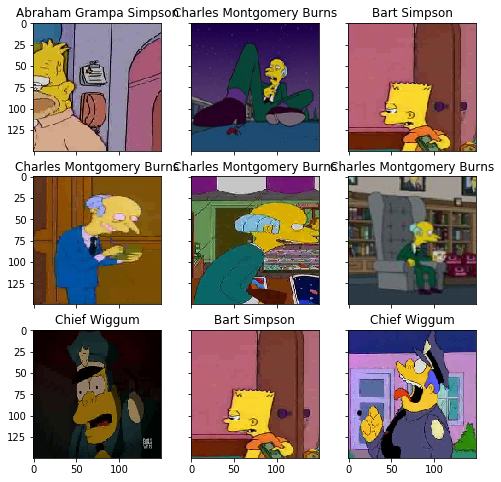

In [78]:
val_dataset = SimpsonsDataset(val_files, mode='val')
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети
В данном задании использую готовую модель нейросети Resnet18, так как она имеет довольно хорошие показатели.

In [10]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Видим, что на вход Fully-Connected слоя подаётся *512 признаков*. Это и будет размер входа для нашего нового fc.
Буду обучать не только последний **fully connected** слой, но и несколько предпоследних.
Так как, все слои нейросети обучаются заново, сделаю так, чтобы на них *не распространялся backpropagation* (заморожу их), и изменю FC-слой. (ведь старый уже с весами для ImageNet'а).

In [85]:
layers_to_unfreeze = 1

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model.layer1[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
for param in model.layer2[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
for param in model.layer3[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
for param in model.layer4[:-layers_to_unfreeze].parameters():
    param.requires_grad = False   
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, 42)
# Использовать GPU
model = model.cuda()
# В качестве cost function используем кросс-энтропию
criterion = nn.CrossEntropyLoss().to(DEVICE)
# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому пять таких списков можно сложить
optimizer_ft = optim.AdamW(list(model.layer1.parameters())[-layers_to_unfreeze:]+
                           list(model.layer2.parameters())[-layers_to_unfreeze:]+
                           list(model.layer3.parameters())[-layers_to_unfreeze:]+
                           list(model.layer4.parameters())[-layers_to_unfreeze:]+
                           list(model.fc.parameters()), lr = 0.001)
# Умножаю learning_rate на 0.1 каждые 3 эпохи
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [86]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [87]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [88]:
def train(train_files, val_files, model, epochs, batch_size):
    #задаём размер батча и перемешиваем train данные
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer_ft)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            exp_lr_scheduler.step(val_loss)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [89]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [90]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [91]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=110)

epoch:   0%|                                            | 0/20 [00:00<?, ?it/s]

loss 0.37081167247792834


epoch:   5%|█▋                               | 1/20 [06:21<2:00:40, 381.08s/it]


Epoch 001 train_loss: 0.3708     val_loss 0.0837 train_acc 0.9157 val_acc 0.9835
loss 0.09082136771862016


epoch:  10%|███▎                             | 2/20 [09:48<1:38:41, 328.95s/it]


Epoch 002 train_loss: 0.0908     val_loss 0.0655 train_acc 0.9793 val_acc 0.9866
loss 0.07015299830393514


epoch:  15%|████▉                            | 3/20 [13:16<1:22:54, 292.62s/it]


Epoch 003 train_loss: 0.0702     val_loss 0.0594 train_acc 0.9829 val_acc 0.9861
loss 0.05935386367883877


epoch:  20%|██████▌                          | 4/20 [16:47<1:11:33, 268.32s/it]


Epoch 004 train_loss: 0.0594     val_loss 0.0557 train_acc 0.9857 val_acc 0.9878
loss 0.054387216834580775


epoch:  25%|████████▎                        | 5/20 [20:17<1:02:40, 250.70s/it]


Epoch 005 train_loss: 0.0544     val_loss 0.0582 train_acc 0.9852 val_acc 0.9871
loss 0.053017477412255064


epoch:  30%|██████████▌                        | 6/20 [23:58<56:23, 241.71s/it]


Epoch 006 train_loss: 0.0530     val_loss 0.0574 train_acc 0.9867 val_acc 0.9883
loss 0.047347606591538624


epoch:  35%|████████████▎                      | 7/20 [27:26<50:11, 231.63s/it]


Epoch 007 train_loss: 0.0473     val_loss 0.0576 train_acc 0.9868 val_acc 0.9869
loss 0.042124878738549774


epoch:  40%|██████████████                     | 8/20 [30:53<44:53, 224.44s/it]


Epoch 008 train_loss: 0.0421     val_loss 0.0583 train_acc 0.9890 val_acc 0.9873
loss 0.043035197191664036


epoch:  45%|███████████████▊                   | 9/20 [34:22<40:16, 219.64s/it]


Epoch 009 train_loss: 0.0430     val_loss 0.0595 train_acc 0.9881 val_acc 0.9871
loss 0.04254677392795047


epoch:  50%|█████████████████                 | 10/20 [37:51<36:04, 216.44s/it]


Epoch 010 train_loss: 0.0425     val_loss 0.0608 train_acc 0.9874 val_acc 0.9869
loss 0.04077970952414124


epoch:  55%|██████████████████▋               | 11/20 [41:17<31:59, 213.24s/it]


Epoch 011 train_loss: 0.0408     val_loss 0.0609 train_acc 0.9887 val_acc 0.9871
loss 0.037460915673396


epoch:  60%|████████████████████▍             | 12/20 [44:43<28:10, 211.32s/it]


Epoch 012 train_loss: 0.0375     val_loss 0.0580 train_acc 0.9891 val_acc 0.9890
loss 0.04112662921275796


epoch:  65%|██████████████████████            | 13/20 [48:09<24:26, 209.45s/it]


Epoch 013 train_loss: 0.0411     val_loss 0.0634 train_acc 0.9890 val_acc 0.9881
loss 0.03836038805809436


epoch:  70%|███████████████████████▊          | 14/20 [51:34<20:49, 208.29s/it]


Epoch 014 train_loss: 0.0384     val_loss 0.0603 train_acc 0.9895 val_acc 0.9866
loss 0.03682485492486241


epoch:  75%|█████████████████████████▌        | 15/20 [55:00<17:17, 207.43s/it]


Epoch 015 train_loss: 0.0368     val_loss 0.0640 train_acc 0.9884 val_acc 0.9861
loss 0.03355480553467745


epoch:  80%|███████████████████████████▏      | 16/20 [58:28<13:50, 207.60s/it]


Epoch 016 train_loss: 0.0336     val_loss 0.0598 train_acc 0.9897 val_acc 0.9876
loss 0.03625327163804369


epoch:  85%|███████████████████████████▏    | 17/20 [1:02:02<10:29, 209.76s/it]


Epoch 017 train_loss: 0.0363     val_loss 0.0620 train_acc 0.9888 val_acc 0.9859
loss 0.035084085142951575


epoch:  90%|████████████████████████████▊   | 18/20 [1:05:39<07:03, 211.78s/it]


Epoch 018 train_loss: 0.0351     val_loss 0.0607 train_acc 0.9895 val_acc 0.9876
loss 0.033122227997881684


epoch:  95%|██████████████████████████████▍ | 19/20 [1:09:25<03:36, 216.18s/it]


Epoch 019 train_loss: 0.0331     val_loss 0.0708 train_acc 0.9899 val_acc 0.9864
loss 0.028987260237835023


epoch: 100%|████████████████████████████████| 20/20 [1:13:17<00:00, 219.88s/it]


Epoch 020 train_loss: 0.0290     val_loss 0.0631 train_acc 0.9912 val_acc 0.9881


In [92]:
loss, acc, val_loss, val_acc = zip(*history)

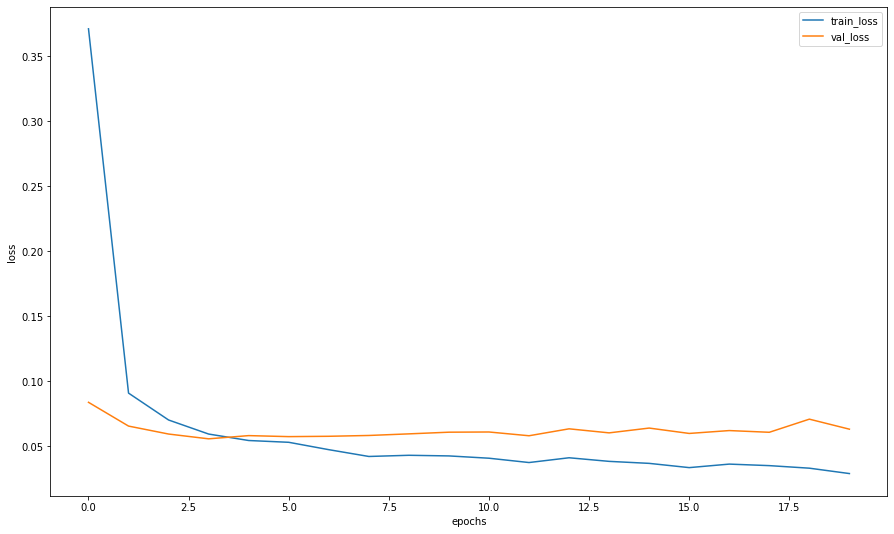

In [93]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Видим, что обучение происходило не со слишком большим переобучением, значит можем использовать модель для предсказания.

У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [94]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [95]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [96]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)

In [97]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [98]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику на валидационной выборке.

In [99]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

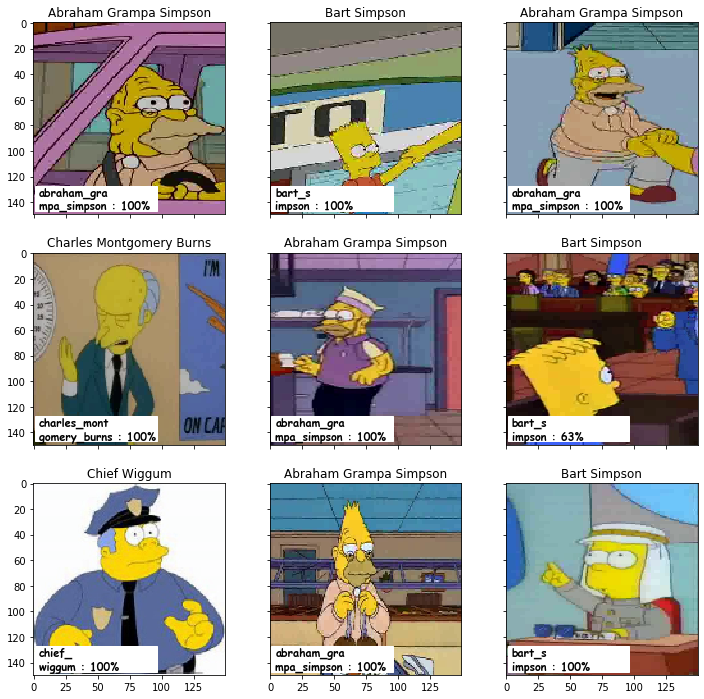

In [111]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((1, 127),95,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(4, 128, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=11, color='black',fontweight='bold')

Сохраним нашу модель:

In [112]:
print("The state dict keys: \n\n", model.state_dict().keys())

The state dict keys: 

 odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight'

We will need to reconstruct the model exactly as it was when trained at loading time, So we need to store information about the model architecture in the checkpoint, along with the state dict.

If you are planning to continue training of the model you'll need to store the optimizer state too.

To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [113]:
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer_ft.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

Видим, что сеть уверенно предсказывает персонажей, значит можно составить submitt и отправить его на проверку.

In [114]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [115]:
import pandas as pd
import pandas as pd
submit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit[f'Expected'] = preds
submit.to_csv('submission.csv', index=False)
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


### Выводы

Изначально необходимо было подготовить данные. Так как их мало, то использовал аугментацию(transforms.ColorJitter, transforms.RandomRotation,transforms.RandomHorizontalFlip) для обучающих данных(train данных). 
Составленная нейросеть, взятая со соревнования, не давала хороших результатов. Чтобы улучшить показатели было принято решение использовать обученную на ImageNet нейросеть Resnet18. Заново обучать её не было смысла, поэтому я заморозил слои, то есть выключил подсчёт их градиентов, и обучал только несколько последних. Метрика на валидационных данных показала 1.0, поэтому улучшать модель дальше не пришлось.